In [1]:
import warnings
warnings.filterwarnings('ignore')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

##### Define paths

In [2]:
train_dir = 'Datasets/archive/train'
valid_dir = 'Datasets/archive/valid'
test_dir = 'Datasets/archive/test'

##### Define transformations

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

##### Load datasets

In [4]:
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

##### Create data loaders

In [5]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Define the model

In [6]:
class WildfireModel(nn.Module):
    def __init__(self):
        super(WildfireModel, self).__init__()
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze all layers except the last few
        for param in self.base_model.parameters():
            param.requires_grad = False
        for param in self.base_model.layer4.parameters():
            param.requires_grad = True
        
        # Add custom layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

##### Initialize model, loss, and optimizer

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WildfireModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)

#### Early stopping

In [8]:
best_val_loss = float('inf')
patience = 5
counter = 0

##### Training loop

In [9]:
from tqdm import tqdm  # For progress bar

def train_model(epochs):
    global best_val_loss, counter
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Progress bar for training batches
        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
        
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Compute batch accuracy
            predicted = (outputs >= 0.5).int()
            batch_correct = (predicted == labels).sum().item()
            batch_total = labels.size(0)
            
            train_loss += loss.item() * batch_total
            correct_train += batch_correct
            total_train += batch_total
            
            # Update progress bar
            train_progress.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{batch_correct / batch_total:.4f}'
            })
        
        train_loss /= total_train
        train_accuracy = correct_train / total_train
        
        # Validation phase (with progress bar)
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        val_progress = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)
        
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                predicted = (outputs >= 0.5).int()
                batch_correct = (predicted == labels).sum().item()
                batch_total = labels.size(0)
                
                val_loss += loss.item() * batch_total
                correct_val += batch_correct
                total_val += batch_total
                
                val_progress.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{batch_correct / batch_total:.4f}'
                })
        
        val_loss /= total_val
        val_accuracy = correct_val / total_val
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}   | Val Acc: {val_accuracy:.4f}')
        
        # Learning rate scheduler
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1}')
                break

# Train the model
train_model(25)


Epoch 1/50:
Train Loss: 0.0773 | Train Acc: 0.9731
Val Loss: 0.0487   | Val Acc: 0.9830



Epoch 2/50:
Train Loss: 0.0337 | Train Acc: 0.9888
Val Loss: 0.0289   | Val Acc: 0.9908



Epoch 3/50:
Train Loss: 0.0214 | Train Acc: 0.9926
Val Loss: 0.0318   | Val Acc: 0.9892



Epoch 4/50:
Train Loss: 0.0123 | Train Acc: 0.9963
Val Loss: 0.0277   | Val Acc: 0.9902



Epoch 5/50:
Train Loss: 0.0120 | Train Acc: 0.9960
Val Loss: 0.0264   | Val Acc: 0.9927



Epoch 6/50:
Train Loss: 0.0064 | Train Acc: 0.9978
Val Loss: 0.0258   | Val Acc: 0.9917



Epoch 7/50:
Train Loss: 0.0074 | Train Acc: 0.9979
Val Loss: 0.0777   | Val Acc: 0.9811



Epoch 8/50:
Train Loss: 0.0047 | Train Acc: 0.9984
Val Loss: 0.0311   | Val Acc: 0.9913



Epoch 9/50:
Train Loss: 0.0065 | Train Acc: 0.9980
Val Loss: 0.0364   | Val Acc: 0.9900



Epoch 10/50:
Train Loss: 0.0025 | Train Acc: 0.9990
Val Loss: 0.0224   | Val Acc: 0.9935



Epoch 11/50:
Train Loss: 0.0012 | Train Acc: 0.9996
Val Loss: 0.0219   | Val Acc: 0.9933



Epoch 12/50:
Train Loss: 0.0010 | Train Acc: 0.9997
Val Loss: 0.0247   | Val Acc: 0.9927



Epoch 13/50:
Train Loss: 0.0005 | Train Acc: 0.9999
Val Loss: 0.0219   | Val Acc: 0.9933



Epoch 14/50:
Train Loss: 0.0003 | Train Acc: 1.0000
Val Loss: 0.0355   | Val Acc: 0.9938



Epoch 15/50:
Train Loss: 0.0003 | Train Acc: 1.0000
Val Loss: 0.0227   | Val Acc: 0.9941



Epoch 16/50:
Train Loss: 0.0002 | Train Acc: 1.0000
Val Loss: 0.0206   | Val Acc: 0.9952



Epoch 17/50:
Train Loss: 0.0002 | Train Acc: 1.0000
Val Loss: 0.0343   | Val Acc: 0.9951



Epoch 18/50:
Train Loss: 0.0003 | Train Acc: 0.9999
Val Loss: 0.0364   | Val Acc: 0.9946



Epoch 19/50:
Train Loss: 0.0002 | Train Acc: 0.9999
Val Loss: 0.0379   | Val Acc: 0.9943



Epoch 20/50:
Train Loss: 0.0001 | Train Acc: 1.0000
Val Loss: 0.0361   | Val Acc: 0.9954



Epoch 21/50:
Train Loss: 0.0002 | Train Acc: 1.0000
Val Loss: 0.0370   | Val Acc: 0.9948

Early stopping at epoch 21


#### Load the best model

In [10]:
all_test_images = []
all_test_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = model(inputs).squeeze()
        predictions = (outputs >= 0.5).int()
        all_test_images.extend(inputs.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())


##### Calculate accuracy

In [11]:
accuracy = accuracy_score(all_test_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9940


##### Classification report

In [12]:
report = classification_report(all_test_labels, all_predictions, target_names=['No Fire', 'Fire'])
print(report)

              precision    recall  f1-score   support

     No Fire       0.99      1.00      0.99      2820
        Fire       1.00      0.99      0.99      3480

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



##### Confusion matrix

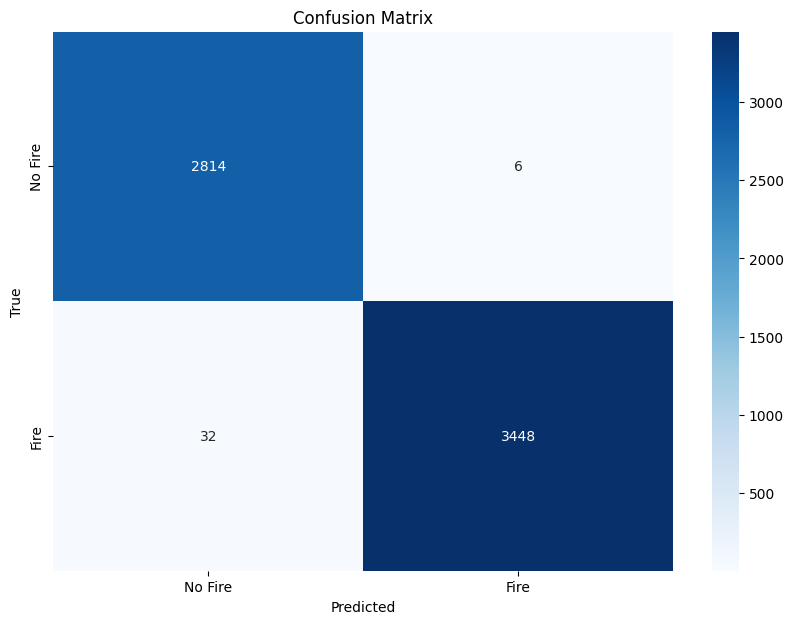

In [13]:
cm = confusion_matrix(all_test_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### Plot some test images with predictions

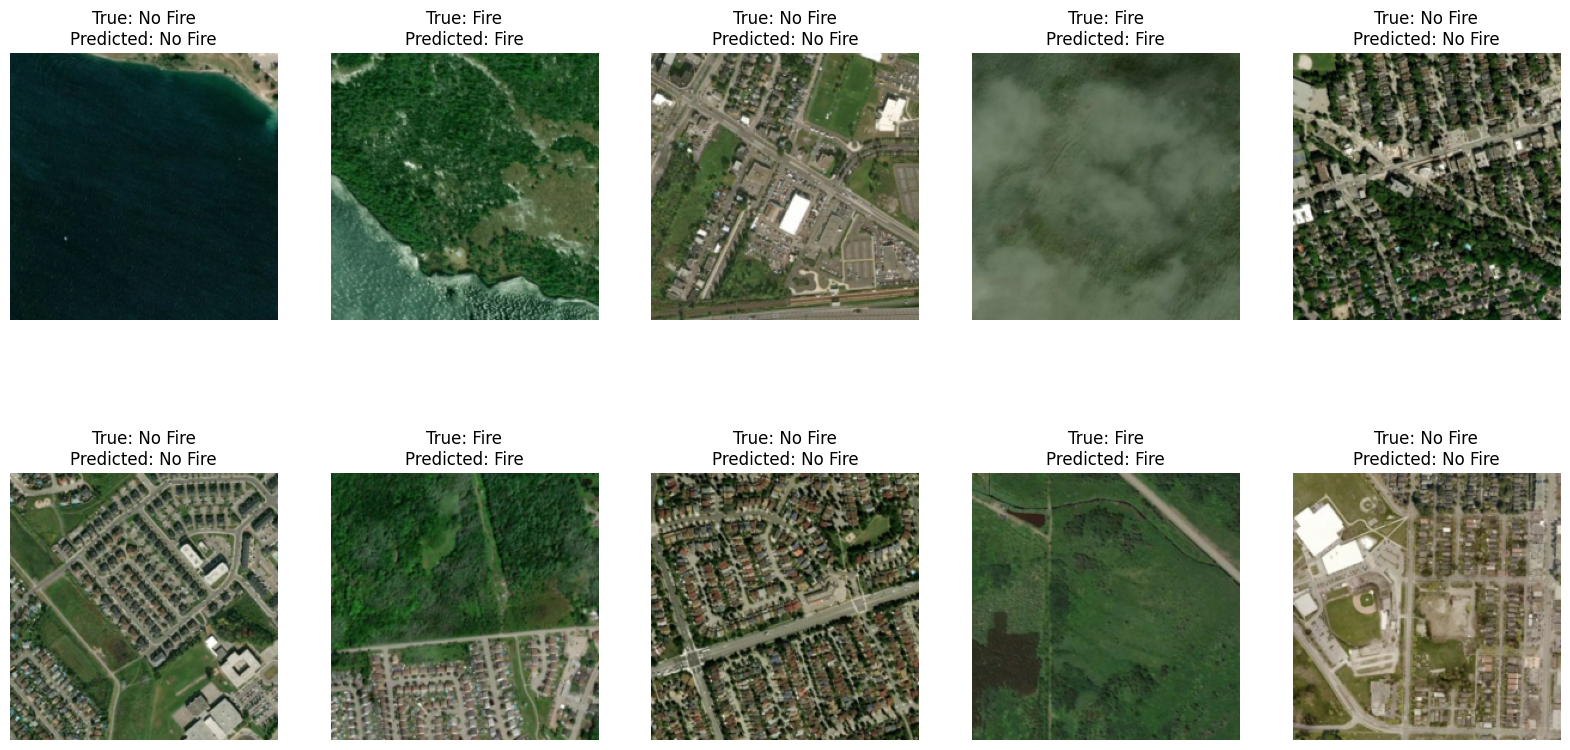

In [14]:
random_indices = np.random.choice(len(all_test_images), 10, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    img = all_test_images[idx].transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Reverse normalization
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    true_label_text = 'Fire' if all_test_labels[idx] == 1 else 'No Fire'
    predicted_label_text = 'Fire' if all_predictions[idx] == 1 else 'No Fire'
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
    plt.axis('off')

plt.show()

##### Save the trained model

In [15]:
torch.save(model.state_dict(), 'wildfire_satellite_detection_model.pth')